In [1]:
from spatial_compare import SpatialCompare
import matplotlib.pyplot as plt
from scanpy import read_h5ad
from IPython.display import HTML

barcode = '1370519421'
seg_name_a = 'XEN'
seg_name_b = 'SIS'
base_path = '/allen/programs/celltypes/workgroups/hct/emilyg/mapping/xen_seg_comp/'
anndata_a = read_h5ad(base_path+'xenium_1370519421_mapped_orig_seg_subset_genes_adj.h5ad') #xenium
anndata_b = read_h5ad(base_path+'xenium_1370519421_mapped_new_seg_subset_genes_adj.h5ad') #sis

#Run segmentation comparison
sc = SpatialCompare(anndata_a, anndata_b, data_names=[seg_name_a, seg_name_b], obsm_key='spatial')
seg_comp_df = sc.collect_mutual_match_and_doublets(bc=barcode, save=True, reuse_saved=False, savepath=base_path, min_transcripts=40)

/home/emilyg/spatial_compare/spatial_compare_2.py:118: UserWarning: category subclass is not in both input AnnData objects
  warnings.warn("category "+category+" is not in both input AnnData objects")


input anndata objects have 240 shared genes
Saved to: /allen/programs/celltypes/workgroups/hct/emilyg/mapping/xen_seg_comp/1370519421_seg_comp_df_XEN_and_SIS_populated.csv


In [2]:
seg_comp_df.head()

,center_x,center_y,source,low_quality_cells,match_XEN_filt_SIS_filt,match_XEN_filt_SIS_unfilt,match_XEN_unfilt_SIS_filt
0,18681.053539,845.912152,XEN,True,NaN,NaN,NaN
1,19110.222886,251.114681,XEN,True,NaN,NaN,NaN
2,19047.897518,224.827737,XEN,True,NaN,NaN,NaN
3,18773.098575,310.760390,XEN,True,NaN,NaN,NaN
4,21347.771140,2224.779555,XEN,True,NaN,NaN,NaN


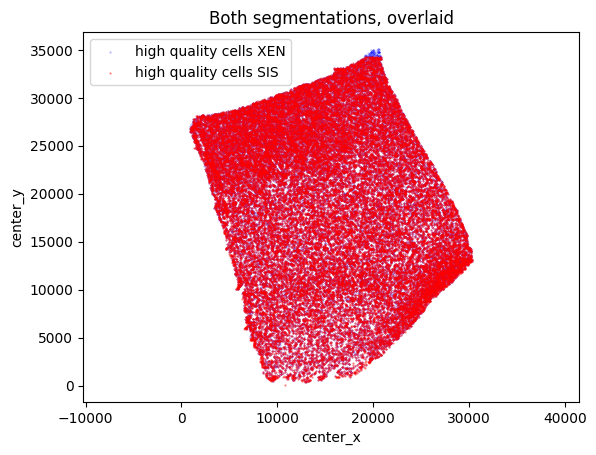

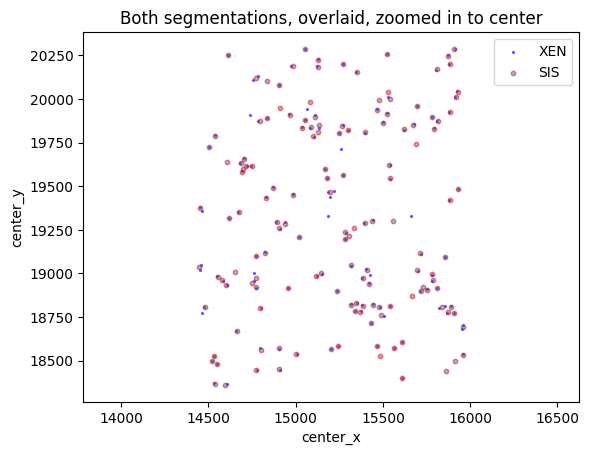

In [3]:
#check that both sections seem (visually) to be scaled correctly 
sc.scaling_check(seg_comp_df)

## Spatial segmentation comparison

The first thing set in the segmentation comparison dataframe is the spatial information for each segmentation result. Below you can see an example of the simple "low quality cell" definition of 40 transcripts for the first of the segmentations. 

Text(0.5, 1.0, '1370519421 all cells overview XEN')

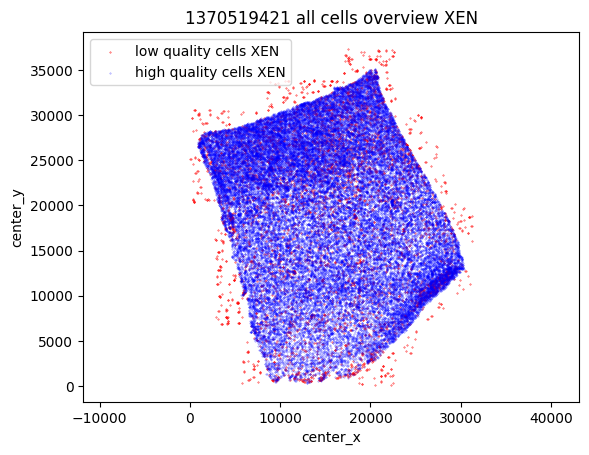

In [4]:
fig, ax = plt.subplots()
filtered_seg_a_df = seg_comp_df[(seg_comp_df['source']==seg_name_a)&(seg_comp_df['low_quality_cells']==True)]
filtered_seg_a_df.plot('center_x', 'center_y', kind='scatter', s=.1, ax=ax, label='low quality cells '+seg_name_a, color='red')
seg_comp_df[(seg_comp_df['source']==seg_name_a)&(seg_comp_df['low_quality_cells']==False)].plot('center_x', 'center_y', kind='scatter', s=.1, label='high quality cells '+seg_name_a, ax=ax, color='blue', alpha=.5)
plt.axis('equal')
plt.title(barcode+' all cells overview '+seg_name_a)


## Next up the mutually matching cells are calculated

The section used to calculate the two segmentations should be the same, but because of minor differences in how a given segmentation method calculates cells, the center x and y locations won't be identical between the two sets of results. To identify which cells are the same in cross_seg_comparison, I use scipy's cKDTree to determine the nearest neighbors for each of the two segmentations.

For our human data, we chose a nearest neighbor distance cutoff (nn_dist) of 2.5um. Within a single segmentation there have been legitimate cells with distinct DAPI stained nuclei as close as approximately 4um across, so this felt like a conservative estimate. See the plot below for an illustration of why this distance was chosen

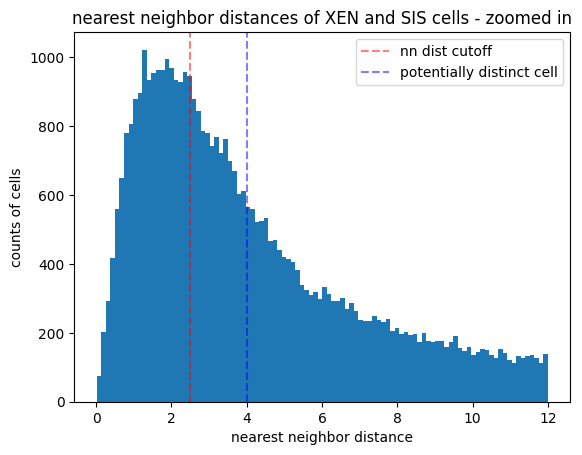

In [5]:
#Nearest neighbor distance cutoff
from scipy.spatial import cKDTree
dfa = seg_comp_df[seg_comp_df['source']==seg_name_a]
dfb = seg_comp_df[seg_comp_df['source']==seg_name_b]
tree = cKDTree(dfa[["center_x", "center_y"]].copy())
dists, inds = tree.query(dfb[['center_x', 'center_y']].copy(), 1)
lim_dists = dists[dists<12] #max is around 350, cutting this off for ease of viewing 
plt.hist(lim_dists, bins=100)
plt.axvline(2.5, c='red', label = 'nn dist cutoff', linestyle='--', alpha=0.5)
plt.axvline(4.0, c='blue', label = 'potentially distinct cell', linestyle='--', alpha=0.5)
plt.title('nearest neighbor distances of '+seg_name_a+' and '+seg_name_b+' cells - zoomed in')
plt.xlabel('nearest neighbor distance')
plt.ylabel('counts of cells')
plt.legend()

### Overview of Mutual Matches

Next, what's interesting to investigate is the layout of the mutually matching (high quality) cells. How well do the two overlap? That data is captured in the 'mutual matches' component of cross_seg_comparison, plotted below

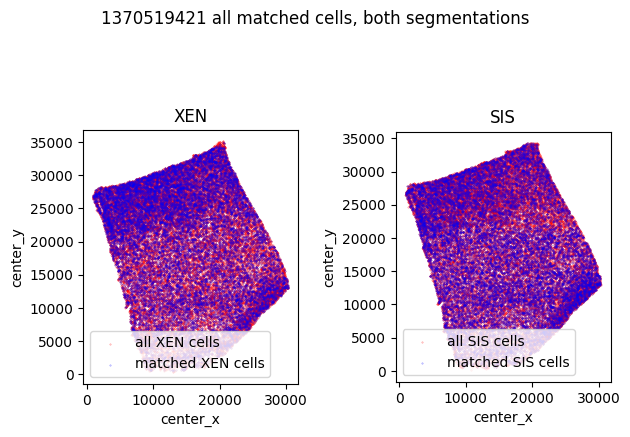

In [6]:
fig, ax = plt.subplots(ncols=2)
seg_names = [seg_name_a, seg_name_b]

for i, name in enumerate(seg_names):
    filtered_seg_df = seg_comp_df[(seg_comp_df['source']==name)&(seg_comp_df['low_quality_cells']==False)]
    filtered_seg_df.plot('center_x', 'center_y', kind='scatter', s=.1, ax=ax[i], label='all '+name+' cells', color='red', alpha=.5)
    filtered_seg_df[filtered_seg_df['match_'+seg_name_a+'_filt_'+seg_name_b+'_filt'].isna()==False].plot('center_x', 'center_y', kind='scatter', s=.1, ax=ax[i], label='matched '+name+' cells', color='blue', alpha=0.5, title=name)
    ax[i].set_aspect('equal', 'box')

plt.suptitle(barcode+' all matched cells, both segmentations')
fig.tight_layout()

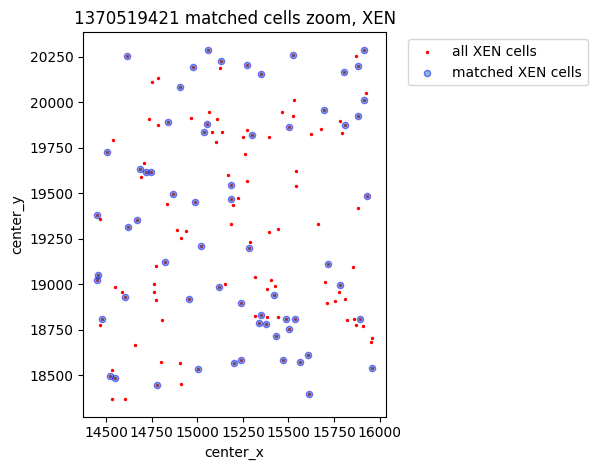

In [7]:
import numpy as np
fig, ax = plt.subplots()

filtered_seg_df = seg_comp_df[(seg_comp_df['source']==seg_name_a)&(seg_comp_df['low_quality_cells']==False)]
arr = filtered_seg_df[['center_x', 'center_y']].values
center = [np.mean(arr[:,0]), np.mean(arr[:,1])]
x_range = [center[0] - center[0]*.05, center[0]+ center[0]*.05]
y_range = [center[1] - center[1]*.05, center[1]+ center[1]*.05]
subs_a = filtered_seg_df[(filtered_seg_df['center_x'].between(x_range[0], x_range[1]))&(filtered_seg_df['center_y'].between(y_range[0], y_range[1]))]

subs_a.plot('center_x', 'center_y', kind='scatter', s=2,ax=ax, label='all '+seg_name_a+' cells', color='red')
subs_a[subs_a['match_'+seg_name_a+'_filt_'+seg_name_b+'_filt'].isna()==False].plot('center_x', 'center_y', kind='scatter', s=20, ax=ax, label='matched '+seg_name_a+' cells', facecolors='none', edgecolors='blue', alpha=0.5)
ax.set_aspect('equal', 'box')

plt.title(barcode+' matched cells zoom, '+seg_name_a)
plt.legend(bbox_to_anchor=[1.05, 1])
fig.tight_layout()

### Mutual match one or the other filtered

But as you can see from the above plots, some cells aren't captured by the mutual matches - they don't have a match across both segmentations. To explore potential causes of this, the first step was to check whether those high quality unmatched cells had pairs in the cells that were filtered out as low quality from the other segmentation

In [8]:

display(seg_comp_df[(seg_comp_df['source']==seg_name_a)&(seg_comp_df['match_'+seg_name_a+'_filt_'+seg_name_b+'_unfilt'].isna()==False)].head())

seg_comp_df[(seg_comp_df['source']==seg_name_b)&(seg_comp_df['match_'+seg_name_a+'_unfilt_'+seg_name_b+'_filt'].isna()==False)].head()



,center_x,center_y,source,low_quality_cells,match_XEN_filt_SIS_filt,match_XEN_filt_SIS_unfilt,match_XEN_unfilt_SIS_filt
86,21928.883272,14766.679688,XEN,False,911,911,911
88,22879.800092,13639.856388,XEN,False,913,913,913
89,22599.556526,13339.911535,XEN,False,46922,46922,46922
235,8065.651425,5647.505744,XEN,False,6811,6811,6811
428,12076.981847,24686.227022,XEN,False,55058,55058,55058


,center_x,center_y,source,low_quality_cells,match_XEN_filt_SIS_filt,match_XEN_filt_SIS_unfilt,match_XEN_unfilt_SIS_filt
86,9632.610352,636.433044,SIS,False,911,911,911
88,9693.821289,662.546875,SIS,False,913,913,913
89,9588.533203,679.086365,SIS,False,46922,46922,46922
90,9634.420898,674.934265,SIS,False,NaN,NaN,914
235,9546.581055,862.058838,SIS,True,6811,6811,6811


### Manual adjustments made to sankey diagram:

Unfortunately, when plotly creates the sankey diagram, it doesn't always organize the results in a human readable way. Oftentimes the links or nodes will overlap, such that the result is muddled.

Below, after running the diagram, I clarify it by manually shifting (as needed):
    
    -  the "low quality cells" nodes to be the outermost of the second level of the diagram,
    -  the "unmatched cells" to the outermost layer of the third (such that the "mutually matched" node is central)
    -  the remaining nodes closer to their parent nodes such that the text doesn't run off the page

Once the diagram is saved as a png, the nodes become static, but I have saved the results as an html figure here such that you can arrange them as you prefer and screenshot/save out the result from there.

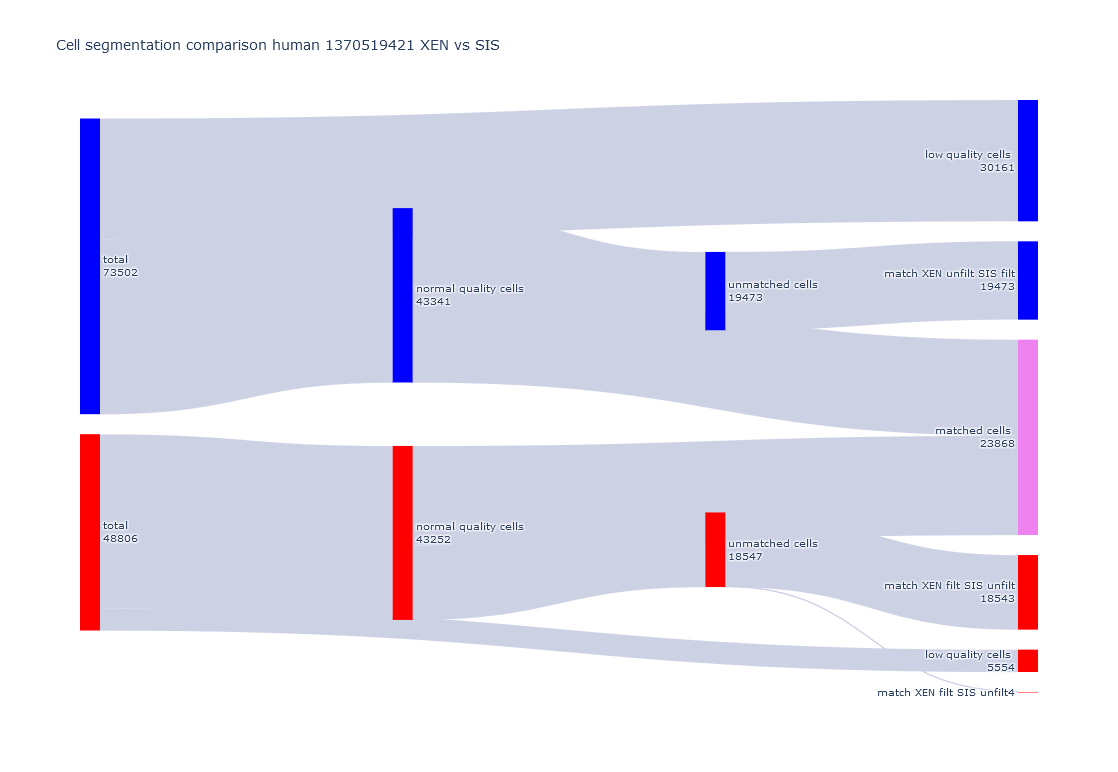

In [4]:
unknown_unmatched_cells, filepath = sc.generate_sankey_diagram(seg_comp_df, barcode, save=True, savepath='/home/emilyg/spatial_compare')

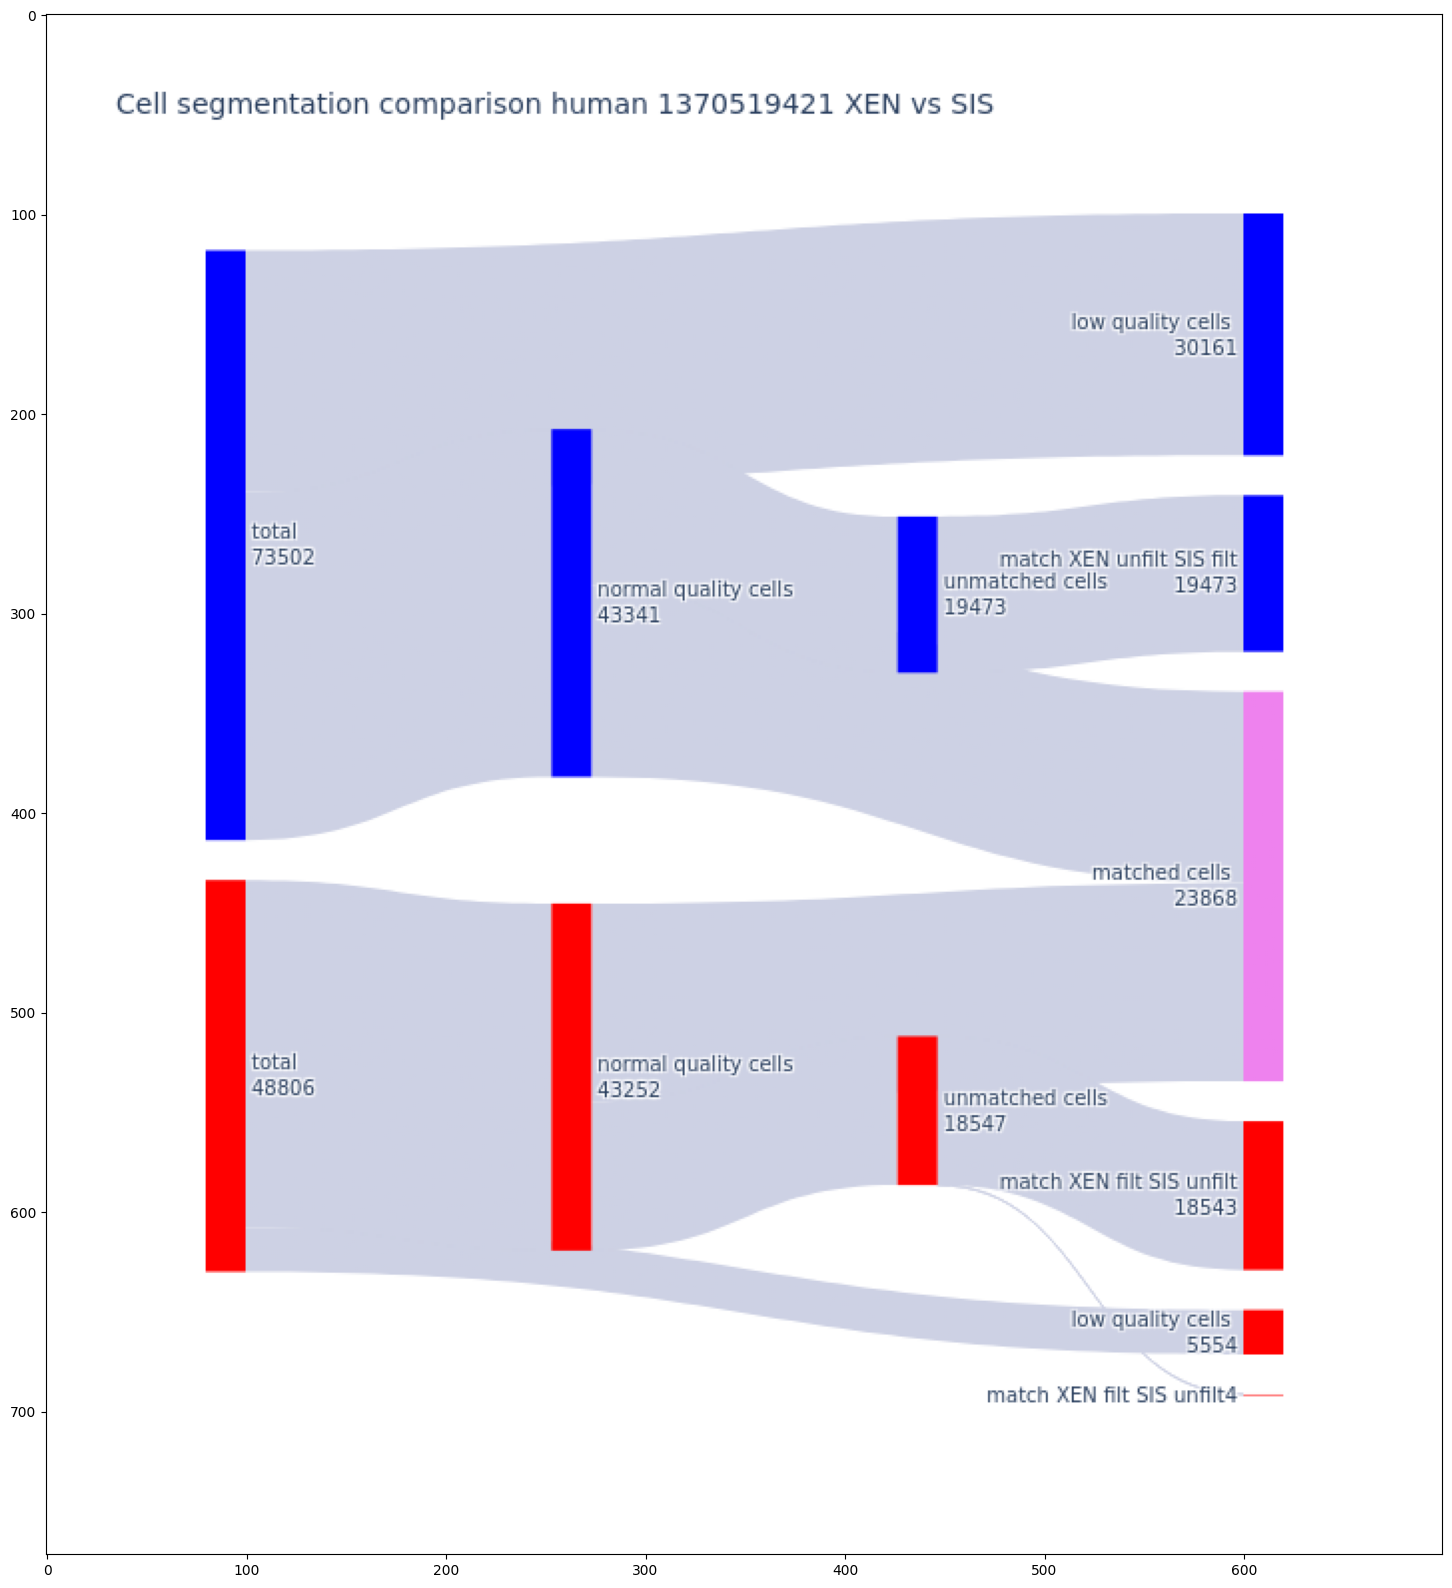

In [13]:
plt.figure(figsize = (30, 20))
test = plt.imread(filepath)
plt.imshow(test) 
plt.show()

In [17]:
unknown_unmatched_cells #view indexes of cells which have no match or cause for lack thereof, along with source

{'XEN': ['16510', '22637', '26550', '46684']}